In [1]:
import numpy as np
import cv2 as cv
import glob
import yaml
import os
from matplotlib import pyplot as plt
# Broj unutrašnjih uglova po X i Y osi na šahovskoj tabli
broj_uglova_x = 9
broj_uglova_y = 6

# Putanja do foldera sa slikama za kalibraciju i file u kojem će se pohraniti rezultati
slike_sahovske_ploce = "sahovskaploca"
izlazni_yaml_fajl = "kamera_kalibracija.yaml"

# Kriterij za poboljšanje preciznosti detekcije uglova
kriterij = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Priprema 3D tačaka šahovske table 
tacke_3d = np.zeros((broj_uglova_x * broj_uglova_y, 3), np.float32)
tacke_3d[:, :2] = np.mgrid[0:broj_uglova_x, 0:broj_uglova_y].T.reshape(-1, 2)

# Liste za 3D tačke u prostoru i 2D tačke na slici
lista_tacaka_3d = []
lista_tacaka_2d = []

# Učitavanje svih slika iz foldera
putanje_slika = glob.glob(os.path.join(slike_sahovske_ploce, '*.jpg'))

for putanja in putanje_slika:
    slika = cv.imread(putanja)
    siva_slika = cv.cvtColor(slika, cv.COLOR_BGR2GRAY) 

    uspjeh, uglovi = cv.findChessboardCorners(siva_slika, (broj_uglova_x, broj_uglova_y), None)

    if uspjeh: #uglovi su pronadjeni
        lista_tacaka_3d.append(tacke_3d)
        precizni_uglovi = cv.cornerSubPix(siva_slika, uglovi, (11, 11), (-1, -1), kriterij)
        lista_tacaka_2d.append(precizni_uglovi)

        cv.drawChessboardCorners(slika, (broj_uglova_x, broj_uglova_y), precizni_uglovi, uspjeh)
        cv.imshow('slika', slika)
        cv.waitKey(500)
    else:
        print(f'Nije pronađena šahovska ploča u slici: {putanja}')

cv.destroyAllWindows()

# Kalibracija kamere
uspjeh, matrica_kamere, koef_distorzije, rotacije, translacije = cv.calibrateCamera(
    lista_tacaka_3d, lista_tacaka_2d, siva_slika.shape[::-1], None, None)

print("Matrica kamere (K):\n", matrica_kamere)
print("Koeficijenti distorzije:\n", koef_distorzije)

# Izračunavanje srednje greške reprojekcije
srednja_greska = 0
for i in range(len(lista_tacaka_3d)):
    projektovane_tacke, _ = cv.projectPoints(
        lista_tacaka_3d[i], rotacije[i], translacije[i], matrica_kamere, koef_distorzije)
    
    greska = cv.norm(lista_tacaka_2d[i], projektovane_tacke, cv.NORM_L2) / len(projektovane_tacke)
    srednja_greska += greska

print("Srednja reprojekcijska greška:", srednja_greska / len(lista_tacaka_3d))

rezultati = {
    'matrica_kamere': matrica_kamere.tolist(),
    'koeficijenti_distorzije': koef_distorzije.tolist()
}

with open(izlazni_yaml_fajl, "w") as f:
    yaml.dump(rezultati, f)

print(f"Rezultati kalibracije sačuvani su u fajl: {izlazni_yaml_fajl}")

Matrica kamere (K):
 [[760.82477986   0.         318.88582581]
 [  0.         763.28549981 262.39572376]
 [  0.           0.           1.        ]]
Koeficijenti distorzije:
 [[-5.93837778e-02 -2.66285033e-01  1.45276412e-03  5.43773235e-04
   1.46175629e+00]]
Srednja reprojekcijska greška: 0.03609999444315531
Rezultati kalibracije sačuvani su u fajl: kamera_kalibracija.yaml


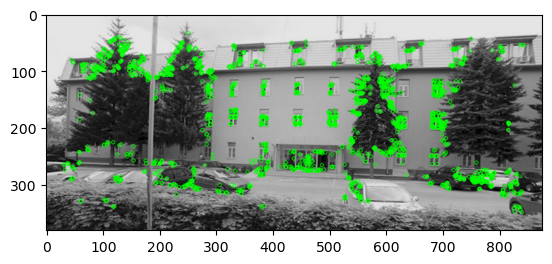

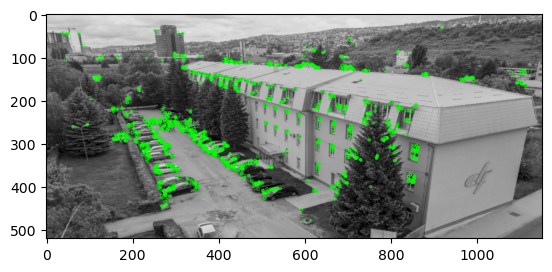

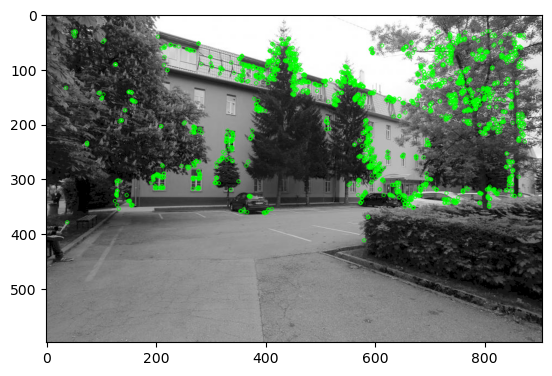

(<matplotlib.image.AxesImage at 0x1f79603caa0>, None)

In [26]:
img1 = cv.imread('zgrada2.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('zgrada1.png', cv.IMREAD_GRAYSCALE)
img3 = cv.imread('zgrada3.png', cv.IMREAD_GRAYSCALE)
# Initiate ORB detector
orb = cv.ORB_create(nfeatures=2000)
# find the keypoints with ORB
kp1 = orb.detect(img1,None)
kp2 = orb.detect(img2,None)
kp3 = orb.detect(img3,None)
# compute the descriptors with ORB
kp1, des1 = orb.compute(img1, kp1)
kp2, des2 = orb.compute(img2, kp2)
kp3, des3 = orb.compute(img3, kp3)
# draw only keypoints location,not size and orientation
img1_2 = cv.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
img2_2 = cv.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)
img3_2 = cv.drawKeypoints(img3, kp3, None, color=(0,255,0), flags=0)
plt.imshow(img1_2), plt.show()
plt.imshow(img2_2), plt.show()
plt.imshow(img3_2), plt.show()

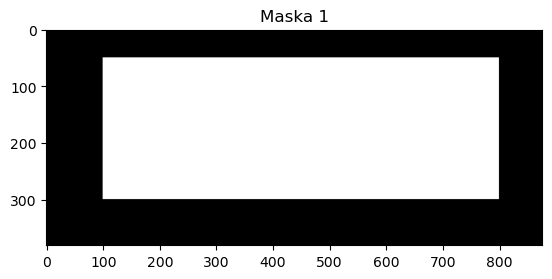

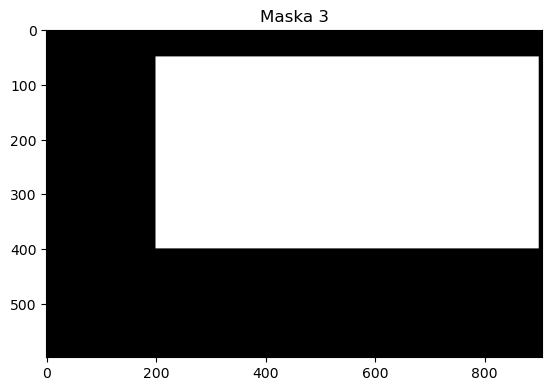

(<matplotlib.image.AxesImage at 0x1f7a820bb60>,
 Text(0.5, 1.0, 'Maska 3'),
 None)

In [43]:
mask1 = np.zeros_like(img1, dtype=np.uint8)
mask3 = np.zeros_like(img3, dtype=np.uint8)

# Ovdje upiši okvir zgrade za svaku sliku
mask1[50:300, 100:800] = 255  # (y1:y2, x1:x2) – za img1
mask3[50:400, 200:900] = 255  # prilagodi za img3
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, mask1)
kp3, des3 = sift.detectAndCompute(img3, mask3)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des3, k=2)

# Lowe ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

plt.imshow(mask1, cmap='gray'), plt.title("Maska 1"), plt.show()
plt.imshow(mask3, cmap='gray'), plt.title("Maska 3"), plt.show()


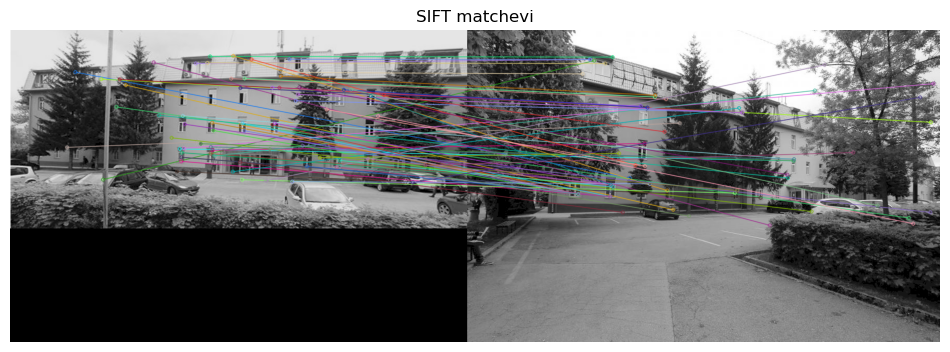

In [44]:
img_matches = cv.drawMatches(img1, kp1, img3, kp3, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12, 6))
plt.imshow(img_matches), plt.title("SIFT matchevi"), plt.axis("off")
plt.show()

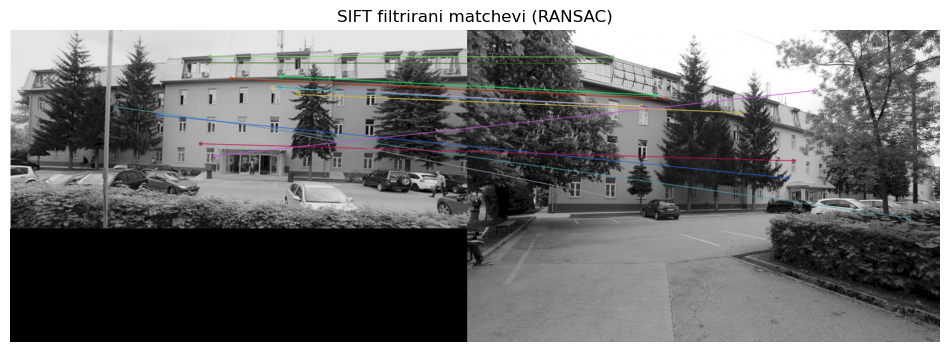

In [45]:
# Ekstrakcija koordinata iz "good" mečeva
pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts3 = np.float32([kp3[m.trainIdx].pt for m in good])

# Provjera da li imamo dovoljno tačaka
if len(pts1) >= 8 and len(pts3) >= 8:
    # Fundamentalna matrica + RANSAC
    F, mask = cv.findFundamentalMat(pts1, pts3, cv.FM_RANSAC)

    if mask is not None:
        # Zadrži samo inliere
        pts1_in = pts1[mask.ravel() == 1]
        pts3_in = pts3[mask.ravel() == 1]
        good_inliers = [good[i] for i in range(len(good)) if mask[i]]

        # Prikaz filtriranih mečeva
        img_filtered = cv.drawMatches(img1, kp1, img3, kp3, good_inliers, None,
                                      flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(12, 6))
        plt.imshow(img_filtered), plt.title("SIFT filtrirani matchevi (RANSAC)"), plt.axis("off")
        plt.show()
    else:
        print("RANSAC nije uspio pronaći fundamentalnu matricu.")
else:
    print(f"Premalo tačaka za RANSAC: {len(pts1)} pronađeno.")
